In [25]:
from __future__ import division
import pandas as pd
import numpy as np
import os
from scipy import cluster
import pickle
# import plotly.plotly as py
import matplotlib.pyplot as plt
%matplotlib inline
import math
from sklearn import preprocessing
import get_metro_features as gmf
import get_city_proportion as gcp
import plot_and_split as pas
import datetime
import scipy
from scipy.sparse import csc_matrix
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
cur_dir = '~/Desktop/dataset/'
dataset_dir = cur_dir # + 'head'
ext = '' #'_head'
CITYNAME = 'LasVegas'

In [6]:
users = pd.read_csv(dataset_dir + '/user' + ext + '.csv')
reviews = pd.read_csv(dataset_dir + '/review' + ext + '.csv')
businesses = pd.read_csv(dataset_dir + '/business' + ext + '.csv')

In [7]:
major_businesses, state_num = pas.eliminate_minor_states(businesses)
# Manually define boundaries because that's the easiest way to do this
boundaries = dict(AZ=dict(bot=31.30, top=37.0, left=-115.0, right=-109),
                 NC=dict(bot=33.8, top=36.8, left=-84.4, right=-75.1),
                 PA=dict(bot=39, top=42.3, left=-80.7, right=-74.6),
                 NV=dict(bot=34.9, top=42.07, left=-120.1, right=-114.02)) 
# One odd point this doesn't clean for NV because of diagonal, but whatever, not worth a more advanced function
for state in state_num:
    if state not in boundaries.keys():
        # All other states are clean
        continue
    # Filter the one's that do need to be filtered
    major_businesses = major_businesses[(major_businesses.state != state) | (major_businesses['latitude'] > boundaries[state]['bot'])]
    major_businesses = major_businesses[(major_businesses.state != state) | (major_businesses['latitude'] < boundaries[state]['top'])]
    major_businesses = major_businesses[(major_businesses.state != state) | (major_businesses['longitude'] > boundaries[state]['left'])]
    major_businesses = major_businesses[(major_businesses.state != state) | (major_businesses['longitude'] < boundaries[state]['right'])]

# Also NC and SC should be combined, because its the same area 
major_businesses.loc[major_businesses.state=='SC', 'state'] = 'NC'

In [8]:
states = set(major_businesses['state'])
print(states)
init = np.zeros((len(states), 2))
for i, state in enumerate(states):
    init_pt = major_businesses[major_businesses['state'] == state].sample(1)
    init[i, 0] = init_pt['latitude']
    init[i, 1] = init_pt['longitude']

# It looks like we have one NaN in lat/lng
major_businesses.dropna(subset=['latitude', 'longitude'], inplace=True)
clusters = pas.cluster_cities(major_businesses, k=11, iter=500, init=init)


{'PA', 'WI', 'BW', 'OH', 'NV', 'AZ', 'QC', 'EDH', 'ON', 'IL', 'NC'}


In [9]:
major_businesses = major_businesses.assign(metro_area=pd.Series(clusters[1]).values)

In [10]:
b = major_businesses.keys()
nonA = [ba for ba in b if 'Attributes' not in ba and 'attributes' not in ba and 'hours' not in ba]
major_businesses2 = major_businesses[nonA]
# major_businesses2.groupby('metro_area')
major_businesses2 = major_businesses2.rename(columns={'review_count':'biz_review_count'})
print(major_businesses2.keys())
np.mean(major_businesses2['biz_review_count'])
# print(np.mean(major_businesses.loc[['biz_review_count']]))

Index(['postal_code', 'latitude', 'business_id', 'categories', 'name',
       'is_open', 'neighborhood', 'biz_review_count', 'state', 'address',
       'city', 'stars', 'longitude', 'metro_area'],
      dtype='object')


30.338707505242702

In [11]:
join_date = pd.to_datetime(users['yelping_since']).dt.date
now_date = datetime.date(2017, 12, 1)
users['weeks_on_yelp'] = (now_date - join_date).dt.days / 7
print(users.shape)
# Eliminate users with less than 20 reviews
users = users[users.review_count >= 20]
print(users.shape)


(1183362, 23)
(251675, 23)


In [12]:
connections = gmf.link_for_metro(users, major_businesses, reviews)
# This gives us percentage of reviews in each metro area
perc_metro = gmf.calc_perc_metro(connections)
# print(perc_metro)




In [13]:
num_visited = gmf.num_metros_visited(perc_metro)
weeks_metro = gmf.calc_num_weeks_metro(num_visited)

Grouped. Now merge


In [14]:
# review_metro = gmf.reviews_per_week_per_metro(weeks_metro)
user_features = gmf.define_user_features(users, weeks_metro, clusters[0].shape[0])
# user_features['num_metros_visited'] = perc_metro.groupby('user_id')['num_metros_visited'].nunique()
# user_features = pd.merge(user_features, dnew, on='user_id', how='left')
user_features.fillna(0, inplace=True)
user_features = user_features.groupby('user_id').max()
user_features = user_features.reset_index()

(2584022, 3)
evaluating metro: 0
(2584022, 5)
evaluating metro: 1
(2584022, 7)
evaluating metro: 2
(2584022, 9)
evaluating metro: 3
(2584022, 11)
evaluating metro: 4
(2584022, 13)
evaluating metro: 5
(2584022, 15)
evaluating metro: 6
(2584022, 17)
evaluating metro: 7
(2584022, 19)
evaluating metro: 8
(2584022, 21)
evaluating metro: 9
(2584022, 23)
evaluating metro: 10
(2584022, 25)


In [15]:
user_f = np.array(user_features[['m0_percent', # removed 'num_metros_visited', 'weeks_on_yelp', 
       'm0_weeks', 'm1_percent', 'm1_weeks', 'm2_percent', 'm2_weeks',
       'm3_percent', 'm3_weeks', 'm4_percent', 'm4_weeks', 'm5_percent',
       'm5_weeks', 'm6_percent', 'm6_weeks', 'm7_percent', 'm7_weeks',
       'm8_percent', 'm8_weeks', 'm9_percent', 'm9_weeks', 'm10_percent',
       'm10_weeks']])
user_f = user_f.astype(float)
initialization = np.zeros((11, user_f.shape[1]))
for i in range(11):
    initialization[i, 2*i] = 1
print(np.max(initialization, axis=1))
# print(initialization)
# print(np.sum(user_f, axis=1)[0:20])
# # print(user_features[0:5])
# # user_fnorm = preprocessing.normalize(user_f, norm='l1', axis=0, copy=True, return_norm=False)
user_clustering = cluster.vq.kmeans2(user_f, initialization, iter=600, minit='matrix')
user_res = user_features.copy()
user_res['group'] = user_clustering[1]
print(np.max(user_clustering[0], axis=1))
print(user_res.keys())

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 0.85855759  0.91143235  0.99026195  0.90988808  0.97470538  0.92835805
  0.89045391  0.94723998  0.92623232  0.93230073  0.948942  ]
Index(['user_id', 'num_metros_visited', 'weeks_on_yelp', 'm0_percent',
       'm0_weeks', 'm1_percent', 'm1_weeks', 'm2_percent', 'm2_weeks',
       'm3_percent', 'm3_weeks', 'm4_percent', 'm4_weeks', 'm5_percent',
       'm5_weeks', 'm6_percent', 'm6_weeks', 'm7_percent', 'm7_weeks',
       'm8_percent', 'm8_weeks', 'm9_percent', 'm9_weeks', 'm10_percent',
       'm10_weeks', 'group'],
      dtype='object')


In [31]:
all_rmse = np.zeros(clusters[0].shape[0])
sizes = np.zeros(clusters[0].shape[0])
user_res['cluster_dist'] = np.zeros(user_res.shape[0])
cluster_keys = [k for k in user_res.keys() if k not in ['user_id', 'group', 'cluster_dist', 'num_metros_visited', 'weeks_on_yelp']]
for m in range(0, clusters[0].shape[0]):
    test_group = user_res.loc[user_res.group == m, cluster_keys]
#     print(test_group)
    user_res.loc[user_res.group == m, 'cluster_dist'] = np.linalg.norm(user_res.loc[user_res.group == m, cluster_keys] - 
                                                                user_clustering[0][m], axis=1)
    diff = user_res.loc[user_res.group == m, cluster_keys] - user_clustering[0][m]
    all_rmse[m] = np.sqrt(np.mean(np.array(diff)**2))
    sizes[m] = diff.shape[0]
    print('rmse for {} = {:.4f}'.format(m, all_rmse[m]))
sizes = sizes/user_res.shape[0]
total_rmse = np.sum(sizes*all_rmse)
print('total rmse = {}'.format(total_rmse))

rmse for 0 = 0.0679
rmse for 1 = 0.0535
rmse for 2 = 0.0163
rmse for 3 = 0.0528
rmse for 4 = 0.0254
rmse for 5 = 0.0460
rmse for 6 = 0.0582
rmse for 7 = 0.0412
rmse for 8 = 0.0459
rmse for 9 = 0.0456
rmse for 10 = 0.0397
total rmse = 0.03700315072547479


[ 0.85855759  0.91143235  0.99026195  0.90988808  0.97470538  0.92835805
  0.89045391  0.94723998  0.92623232  0.93230073  0.948942  ]
(251675, 27)
(array([ 188126.,   32298.,    4863.,    3994.,    4859.,    4882.,
          3428.,    8139.,     605.,     481.]), array([ 0.01039798,  0.09532985,  0.18026173,  0.2651936 ,  0.35012547,
        0.43505735,  0.51998922,  0.60492109,  0.68985296,  0.77478484,
        0.85971671]), <a list of 10 Patch objects>)


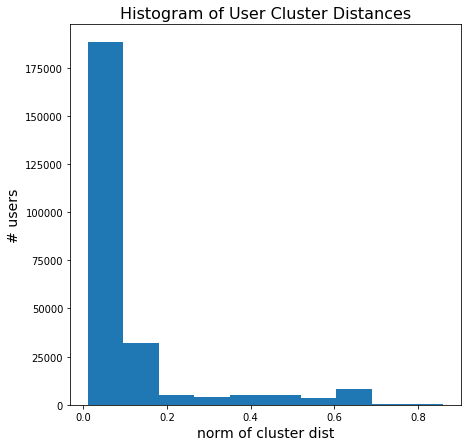

In [42]:
print(np.max(user_clustering[0], axis=1))
print(user_res.shape)
plt.figure(figsize=(7, 7))
print(plt.hist(user_res['cluster_dist'], 10))
plt.title('Histogram of User Cluster Distances', fontsize=16)
plt.xlabel('norm of cluster dist', fontsize=14)
plt.ylabel('# users', fontsize=14)
plt.savefig('plots/user_cluster_distances.png')

In [20]:
city_centers = dict(
    Toronto=(43.66, -79.58),
    LasVegas=(36.0, -115.0),
    Edinburgh=(55.0, -3.19),
    Pittsburgh=(40.12, -80.12),
    Madison=(43.07, -89.38),
    Champaign=(40.08, -88.29),
    Stuttgart=(48.71, 9.23),
    Phoenix=(33.39, -111.91),
    Cleveland=(41.18, -81.49),
    Charlotte=(35.25, -80.79),
    Montreal=(45.58, -73.54)
)

def closest_value(compare, lat, lng):
    mindist = 1e6
    mindex = -1
    for k in compare:
        temp = np.linalg.norm([compare[k][0] - lat, compare[k][1] - lng])
        if temp < mindist:
            mindex = k
            mindist = temp
#             print('new mindist = {}'.format(mindist))
    return mindex


cities = dict()
city_bs = dict()
for i in range(clusters[0].shape[0]):
    city_locals = user_res[user_res['group'] == i]
    connection_locals = connections[connections['user_id'].isin(city_locals['user_id'])]
    mean_lat, mean_lng = np.mean(connection_locals['latitude']), np.mean(connection_locals['longitude'])
#     print(mean_lat, mean_lng)
    city = closest_value(city_centers, mean_lat, mean_lng)
    cities[city] = i
    print('User city {} = {}\t {:.2f}, {:.2f}'.format(city, i, mean_lat, mean_lng))
    
    # Now do businesses
    business_locals = major_businesses[major_businesses['metro_area'] == i]
    print('size = {}'.format(business_locals.shape))
    mean_lat, mean_lng = np.mean(business_locals['latitude']), np.mean(business_locals['longitude'])
    city = closest_value(city_centers, mean_lat, mean_lng)
    city_bs[city] = i
    print('Biz city  {} = {}\t {:.2f}, {:.2f}'.format(city, i, mean_lat, mean_lng))
    print('===================================')
# print(cities)

User city Cleveland = 0	 40.30, -81.30
size = (8912, 102)
Biz city  Pittsburgh = 0	 40.44, -79.95
User city Madison = 1	 42.70, -89.98
size = (4194, 102)
Biz city  Madison = 1	 43.07, -89.40
User city Stuttgart = 2	 48.67, 8.00
size = (3071, 102)
Biz city  Stuttgart = 2	 48.77, 9.17
User city Cleveland = 3	 41.17, -82.88
size = (10931, 102)
Biz city  Cleveland = 3	 41.42, -81.65
User city LasVegas = 4	 36.17, -114.33
size = (30568, 102)
Biz city  LasVegas = 4	 36.12, -115.18
User city Phoenix = 5	 33.69, -111.69
size = (47363, 102)
Biz city  Phoenix = 5	 33.49, -111.99
User city Montreal = 6	 44.88, -75.72
size = (7276, 102)
Biz city  Montreal = 6	 45.52, -73.61
User city Edinburgh = 7	 55.31, -6.78
size = (3560, 102)
Biz city  Edinburgh = 7	 55.95, -3.20
User city Toronto = 8	 43.57, -79.87
size = (26514, 102)
Biz city  Toronto = 8	 43.71, -79.43
User city Champaign = 9	 40.00, -88.98
size = (1663, 102)
Biz city  Champaign = 9	 40.11, -88.25
User city Charlotte = 10	 35.33, -81.70
siz

In [18]:

city_centers = """
#: \tlat, lng =\tCity
0:\t43.60, 79.50=\tToronto
1:\t36.0, -115.0=\tLas Vegas
2:\t55.0, -3.19=\tEdinburgh
3:\t43.0, -79.9=\tPittsburgh
4:\t43.07, -89.38=\tMadison
5:\t40.08, -88.29=\tChampaign
6:\t48.71, 9.23=\tStuttgart
7:\t33.39, -111.91=\tPhoenix
8:\t41.18, -81.49=\tCleveland
9:\t35.25, -80.79=\tCharlotte
10:\t45.58, -73.54=\tMontreal
"""
# print(city_centers)


In [171]:
def get_city_array(city_index, connections, user_res, businesses, savename=None):
    local_users = user_res[user_res['group'] == city_index]
    local_bizes = businesses[businesses['metro_area'] == city_index]
    local_connections = connections[connections['user_id'].isin(local_users['user_id'])]
    local_connections = local_connections[local_connections['business_id'].isin(local_bizes['business_id'])]
                                    
    local_users = set(local_connections.user_id)
    local_businesses = set(local_connections.business_id)
    local_data = local_connections['stars'].tolist()
    local_col = local_connections.user_id.astype('category', categories=local_users).cat.codes
    local_row = local_connections.business_id.astype('category', categories=local_businesses).cat.codes
    assert(local_col[local_col<0].shape[0] == 0)
    assert(local_row[local_row<0].shape[0] == 0)
    local_sparse_matrix = csc_matrix((local_data, (local_row, local_col)), 
                                     shape=(len(local_businesses), len(local_users)))
    
    if savename is not None:
        pickle.dump(local_sparse_matrix, open('data/{}_local.pck'.format(savename), 'wb'))
    
    # For tourist, get new users but same businesses
    tourist_users = user_res[user_res['group'] != city_index]
    tourist_bizes = businesses[businesses['metro_area'] == city_index]
    tourist_connections = connections[connections['user_id'].isin(tourist_users['user_id'])]
    tourist_connections = tourist_connections[tourist_connections['business_id'].isin(tourist_bizes['business_id'])]
    
    tourist_users = set(tourist_connections.user_id)
    tourist_businesses = set(tourist_connections.business_id)
    tourist_data = tourist_connections['stars'].tolist()
    tourist_col = tourist_connections.user_id.astype('category', categories=tourist_users).cat.codes
    tourist_row = tourist_connections.business_id.astype('category', categories=tourist_businesses).cat.codes
    assert(tourist_row[tourist_row<0].shape[0] == 0)
    assert(tourist_col[tourist_col<0].shape[0] == 0)
    tourist_sparse_matrix = csc_matrix((tourist_data, (tourist_row, tourist_col)), 
                                       shape=(len(tourist_businesses), len(tourist_users)))
    
    print('local sparse shape: {}'.format(local_sparse_matrix.shape))
    print('tourist sparse shape: {}'.format(tourist_sparse_matrix.shape))
    if savename is not None:
        pickle.dump(tourist_sparse_matrix, open('data/{}_tourist.pck'.format(savename), 'wb'))
    return local_sparse_matrix,  tourist_sparse_matrix


variables = dict(
    cities=cities,
    connections=connections, 
    user_res=user_res,
    major_businesses=major_businesses,
    CITYNAME=CITYNAME
)

# pickle.dump(variables, open('data/variables.pck', 'wb'))
_, _ = get_city_array(cities[CITYNAME], connections, user_res, major_businesses, CITYNAME)

    
    
    
    
    
    

(107, 2846)
(107, 19)


/Users/Andy/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:10: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
/Users/Andy/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:11: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
/Users/Andy/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:27: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
/Users/Andy/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:28: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


In [135]:
# user_res.keys()
# LV_users = user_res[user_res['group'] == 1]
# LV_businesses = major_businesses[major_businesses['metro_area'] == 1]
# # LV_connections = connections[connections['user_id'].isin(m0_users['user_id'])]
# print(connections.shape)
# LV_connections = connections[connections['user_id'].isin(LV_users['user_id'])]
# print(LV_connections.shape)
# LV_connections = LV_connections[LV_connections['business_id'].isin(LV_businesses['business_id'])]
# print(LV_connections.shape)


# # connections.user_id

# LV_local = LV_connections.pivot(index='user_id', columns='business_id', values='stars')
# # print(LV_local)
# print(LV_local.shape)
# LV_nonnan = LV_local[np.isnan(LV_local) == False]
# # ~np.isnan(LV_local) == True
# print(LV_nonnan)
# # LV_sparse = scipy.sparse.csr_matrix(LV_local.values.T)
# # print(LV_sparse.shape)

# # c_maxes = connections.groupby(['user_id', 'business_id']).review_count.transform(max)
# # c2 = connections[connections.review_count == c_maxes]
# # # print(connections.shape)
# # # print(c2.shape)

In [92]:


# LV_users = set(LV_connections.user_id)
# LV_businesses = set(LV_connections.business_id)

# data = LV_connections['stars'].tolist()
# col = LV_connections.user_id.astype('category', categories=LV_users).cat.codes
# row = LV_connections.business_id.astype('category', categories=LV_businesses).cat.codes
# sparse_matrix = csc_matrix((data, (row, col)), shape=(len(LV_businesses), len(LV_users)))

/Users/Andy/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
/Users/Andy/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
